In [7]:
!pip install pymorphy2 --q
!pip install typing_extensions==4.7.1 --upgrade --q
!python -m spacy download ru_core_news_sm --q
!pip install jsonlines

✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [250]:
import requests
import pandas as pd
from pymorphy2 import MorphAnalyzer
import spacy
from spacy.lang.ru.examples import sentences
from spacy import displacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
import jsonlines
from collections import Counter
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np


nltk.download('stopwords')
nltk.download('punkt')
morph = MorphAnalyzer()
nlp = spacy.load("ru_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
url = 'http://lib.ru/LONDON/smoke.txt_Ascii.txt'
text = requests.get(url).text

In [10]:
len(text)

502630

In [41]:
text = text.translate(str.maketrans('', '', string.punctuation))
text =\
text.replace('\r', '').replace('\x14', '')\
.replace('\x15', '').replace('\n', ' ')
text = re.sub(' +', ' ', text)

#2

In [42]:
doc = nlp(text)

In [162]:
parsed_words = [{'lemma': token.lemma_,
                 'word': token.text,
                 'pos': token.pos_} for token in doc]

with jsonlines.open('parsed_words.jsonl', mode='w') as writer:
    writer.write_all(parsed_words)

In [163]:
df = pd.DataFrame(parsed_words)

df = df.drop('word', axis=1)

df['frequency'] = df.lemma.map(df.lemma.value_counts(normalize=True))

df = df.sort_values(by='frequency')[::-1].drop_duplicates().reset_index()\
.drop('index', axis=1)

df = df[df.pos != 'SPACE']

In [164]:
df.to_csv('df.csv', index=False)

In [165]:
df

,lemma,pos,frequency
0,и,CCONJ,0.041350
1,и,PART,0.041350
2,и,PROPN,0.041350
3,в,ADP,0.021436
4,в,ADV,0.021436
...,...,...,...
11459,впасть,VERB,0.000013
11460,слезть,VERB,0.000013
11461,городишко,NOUN,0.000013
11462,провожать,VERB,0.000013


#3

In [166]:
words = word_tokenize(text, language='russian')

In [167]:
sw = stopwords.words('russian')
words = [w.lower() for w in words if w.lower() not in sw]

In [168]:
parsed_words_2 = []
for w in words:
    parsed = morph.parse(w)[0]
    parsed_words_2.append(
        {'lemma': parsed.normal_form,
         'word': parsed.word,
         'pos': parsed.tag.POS})

with jsonlines.open('parsed_words_2.jsonl', mode='w') as writer:
    writer.write_all(parsed_words)

In [169]:
df_2 = pd.DataFrame(parsed_words_2)

df_2 = df_2.drop('word', axis=1)

df_2['frequency'] = df_2.lemma.map(df_2.lemma.value_counts(normalize=True))

df_2 = df_2.sort_values(by='frequency')[::-1].drop_duplicates().reset_index()\
.drop('index', axis=1)


In [170]:
df_2.to_csv('df_2.csv', index=False)

In [171]:
df_2

,lemma,pos,frequency
0,смокнуть,VERB,0.019423
1,малыш,NOUN,0.012525
2,это,PRCL,0.010492
3,это,NPRO,0.010492
4,сказать,VERB,0.009383
...,...,...,...
10076,промочить,VERB,0.000021
10077,простудиться,INFN,0.000021
10078,давность,NOUN,0.000021
10079,обыкновение,NOUN,0.000021


#4

In [173]:
df = pd.read_csv('df.csv')
df_2 = pd.read_csv('df_2.csv')

In [174]:
df['pos_freq_1'] = df.pos.map(df.pos.value_counts(normalize=True))
df_2['pos_freq_2'] = df_2.pos.map(df_2.pos.value_counts(normalize=True))

In [175]:
df = df.drop_duplicates(subset=['pos'])
df_2 = df_2.drop_duplicates(subset=['pos'])

In [176]:
df = df.drop(['lemma', 'frequency'], axis=1)
df_2 = df_2.drop(['lemma', 'frequency'], axis=1)

In [177]:
parallel = {'ADJF': 'ADJ',
            'ADJS': 'ADJ',
            'COMP': 'ADJ',
            'INFN': 'VERB',
            'PRTF': 'VERB',
            'PRTS': 'VERB',
            'GRND': 'VERB',
            'NUMR': 'NUM',
            'ADVB': 'ADV',
            'NPRO': 'PRON',
            'PRED': 'ADV', # not really but eh
            'PREP': 'ADP',
            'PRCL': 'PART'}

reverse_parallel = {'PROPN': 'NOUN',
                    'CCONJ': 'CONJ',
                    'SCONJ': 'CONJ',
                    'AUX': 'VERB', # cause it's быть/стать
                    'DET': 'ADJ'}


In [178]:
df_2 = df_2.replace({'pos': parallel})

In [179]:
df = df.replace({'pos': reverse_parallel})

In [180]:
df = df.groupby('pos').sum().reset_index()
df_2 = df_2.groupby('pos').sum().reset_index()

In [181]:
df_3 = df.merge(df_2, how='outer', on='pos')

In [182]:
df_3 = df_3[df_3.pos != 'X'].fillna(value=0)

In [192]:
df_4 = pd.DataFrame(np.repeat(df_3, 2, axis=0))
df_4.columns = df_3.columns

In [193]:
df_4['package'] = np.where(df_4.index % 2, 'pymorphy', 'spacy')
df_4['frequency'] = np.where(df_4.index % 2, df_4.pos_freq_2, df_4.pos_freq_1)

In [194]:
df_4 = df_4.drop(['pos_freq_1', 'pos_freq_2'], axis=1)

In [195]:
df_4

,pos,package,frequency
0,ADJ,spacy,0.132851
1,ADJ,pymorphy,0.149373
2,ADP,spacy,0.006019
3,ADP,pymorphy,0.003386
4,ADV,spacy,0.067428
5,ADV,pymorphy,0.069408
6,CONJ,spacy,0.002966
7,CONJ,pymorphy,0.002987
8,INTJ,spacy,0.0
9,INTJ,pymorphy,0.003187


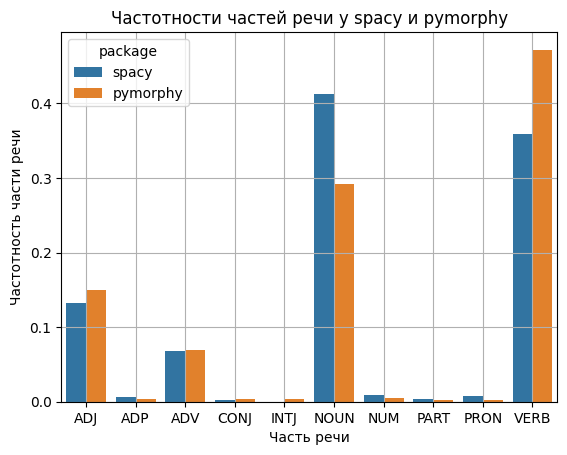

In [196]:
sns.barplot(data=df_4,
            x='pos',
            y='frequency',
            hue='package')
plt.ylabel('Частотность части речи')
plt.xlabel('Часть речи')
plt.title('Частотности частей речи у spacy и pymorphy')
plt.grid()
plt.show()

Есть небольшие различия. Похоже, что pymorphy больше склонен относить трудное в этом плане слово к глагольному, а spacy - к именному. А так, в целом, норм

In [197]:
df_1 = pd.read_csv('df.csv')
df_2 = pd.read_csv('df_2.csv')

In [211]:
verb_1 = df_1[df_1.pos == 'VERB'].sort_values('frequency')[::-1].head(20)
verb_1

,lemma,pos,frequency
14,смок,VERB,0.012107
22,быть,VERB,0.007922
37,сказать,VERB,0.005605
67,мочь,VERB,0.002880
79,знать,VERB,0.002560
94,стать,VERB,0.001971
114,нет,VERB,0.001728
119,идти,VERB,0.001638
121,ответить,VERB,0.001536
128,хотеть,VERB,0.001497


In [212]:
verb_2 = df_2[df_2.pos == 'VERB'].sort_values('frequency')[::-1].head(20)
verb_2

,lemma,pos,frequency
0,смокнуть,VERB,0.019423
4,сказать,VERB,0.009383
10,знать,VERB,0.004250
17,идти,VERB,0.003470
22,мочь,VERB,0.003326
25,стать,VERB,0.003224
36,хотеть,VERB,0.002546
38,ответить,VERB,0.002484
41,говорить,VERB,0.002402
49,видеть,VERB,0.002217


В целом похоже. Есть, во-первых, различия в нормализации. Во-вторых, некоторых слов просто нет у какого-то их пакетов. Так, например, 'быть' есть как глагол в pymorphy, но в spacy он записан как AUX (то бишь вспомонательный глагол, несущий только грамматическое значение). Наоборот с 'нет' и т.д.

In [215]:
adv_1 = df_1[df_1.pos == 'ADV'].sort_values('frequency')[::-1].head(20)
adv_1

,lemma,pos,frequency
4,в,ADV,0.021436
17,с,ADV,0.010136
36,по,ADV,0.005695
39,как,ADV,0.005452
53,ещё,ADV,0.003724
54,так,ADV,0.003596
58,все,ADV,0.003366
65,когда,ADV,0.003007
80,уже,ADV,0.002560
82,до,ADV,0.002547


In [216]:
adv_2 = df_2[df_2.pos == 'ADVB'].sort_values('frequency')[::-1].head(20)\
.replace({'pos': {'ADVB': 'ADV'}})
adv_2

,lemma,pos,frequency
58,снова,ADV,0.002094
69,несколько,ADV,0.001992
88,сколько,ADV,0.001622
121,вперёд,ADV,0.001294
163,вниз,ADV,0.001109
177,пока,ADV,0.001068
191,сюда,ADV,0.001006
211,прямо,ADV,0.000965
208,назад,ADV,0.000965
206,очень,ADV,0.000965


Ну ... у spacy более широкое понимания наречий. Pymorphy все же относит такие слова как 'с', 'в', 'по' к другим, более привычным категориям. Но, в целом, их можно определить и как наречия (that's evil tho)

In [218]:
verb_1['package'] = 'spacy'
verb_2['package'] = 'pymorphy'
adv_1['package'] = 'spacy'
adv_2['package'] = 'pymorphy'

In [236]:
verb_1 = verb_1.reset_index().drop('index', axis=1)
verb_2 = verb_2.reset_index().drop('index', axis=1)
adv_1 = adv_1.reset_index().drop('index', axis=1)
adv_2 = adv_2.reset_index().drop('index', axis=1)

In [241]:
verb_1['group_index'] = verb_1.index
verb_2['group_index'] = verb_2.index
adv_1['group_index'] = adv_1.index
adv_2['group_index'] = adv_1.index


In [244]:
verbs = pd.concat([verb_1, verb_2]).reset_index().drop('index', axis=1)
advs = pd.concat([adv_1, adv_2]).reset_index().drop('index', axis=1)

In [245]:
verbs

,lemma,pos,frequency,package,group_index
0,смок,VERB,0.012107,spacy,0
1,быть,VERB,0.007922,spacy,1
2,сказать,VERB,0.005605,spacy,2
3,мочь,VERB,0.002880,spacy,3
4,знать,VERB,0.002560,spacy,4
5,стать,VERB,0.001971,spacy,5
6,нет,VERB,0.001728,spacy,6
7,идти,VERB,0.001638,spacy,7
8,ответить,VERB,0.001536,spacy,8
9,хотеть,VERB,0.001497,spacy,9


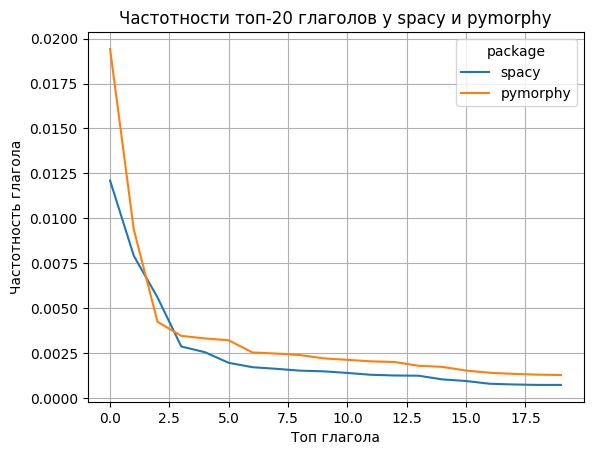

In [246]:
sns.lineplot(data=verbs,
             x='group_index',
             y='frequency',
             hue='package')
plt.ylabel('Частотность глагола')
plt.xlabel('Топ глагола')
plt.title('Частотности топ-20 глаголов у spacy и pymorphy')
plt.grid()
plt.show()

Опять же, pymorphy - про-глагольный

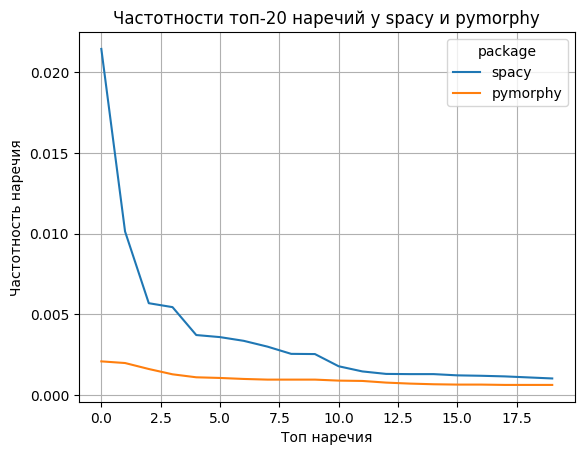

In [247]:
sns.lineplot(data=advs,
             x='group_index',
             y='frequency',
             hue='package')
plt.ylabel('Частотность наречия')
plt.xlabel('Топ наречия')
plt.title('Частотности топ-20 наречий у spacy и pymorphy')
plt.grid()
plt.show()

там у spacy треш с наречиями какой-то. а так должны выровняться, чем меньше топ

для облака слова я буду использовать леммы, полученные в 3-ем задании, потому что я так захотел, и вообще, я не должен этого писать и объяснять вам

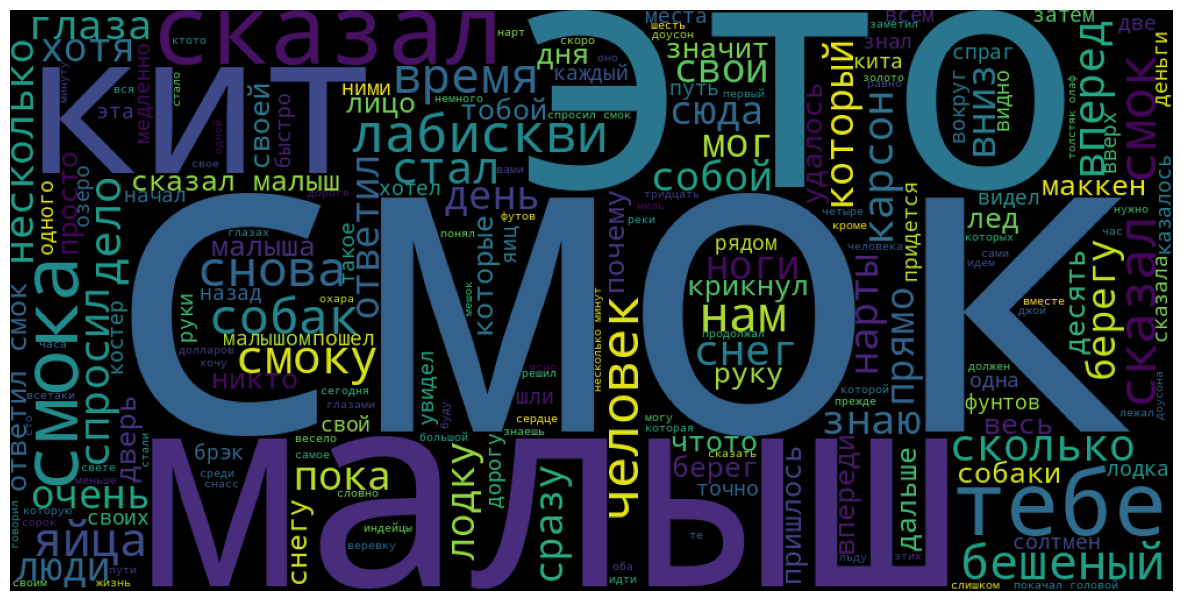

In [257]:
unique_string = (" ").join(words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()


#5

In [265]:
bigrams_words = list(nltk.bigrams(words))
bigrams_syms = list(nltk.bigrams(list(''.join(words))))
trigrams_words = list(nltk.ngrams(words, 3))
trigrams_syms = list(nltk.ngrams(list(''.join(words)), 3))

In [262]:
Counter(bigrams_words).most_common(25)

[(('сказал', 'смок'), 93),
 (('сказал', 'малыш'), 42),
 (('ответил', 'смок'), 38),
 (('покачал', 'головой'), 30),
 (('спросил', 'смок'), 28),
 (('несколько', 'минут'), 25),
 (('смок', 'малыш'), 25),
 (('толстяк', 'олаф'), 25),
 (('джон', 'беллью'), 23),
 (('десять', 'долларов'), 23),
 (('сказал', 'кит'), 21),
 (('калтус', 'джордж'), 21),
 (('джой', 'гастелл'), 19),
 (('смок', 'это'), 19),
 (('ответил', 'малыш'), 18),
 (('нежданное', 'озеро'), 16),
 (('это', 'просто'), 15),
 (('друг', 'друга'), 15),
 (('пять', 'тысяч'), 15),
 (('малыш', 'это'), 14),
 (('двадцать', 'пять'), 14),
 (('смок', 'увидел'), 14),
 (('смок', 'беллью'), 13),
 (('спраг', 'стайн'), 13),
 (('тысяч', 'долларов'), 13)]

Самый распрастраненные биграммы - VO (что логично для русского языка). еще частые: названия/имена (они неразрывные), устойчивые выражения (типа 'друг друга', т.к. неразрывные), числительные (числительные - одни из немногих целостных конструкций на подобии имя+фамилия, а в рассказе они нужны/цитируются несколько раз) и проч. свойственные исключительно для данного текста.

In [263]:
Counter(bigrams_syms).most_common(25)

[(('а', 'л'), 4870),
 (('с', 'т'), 4290),
 (('п', 'о'), 3476),
 (('т', 'о'), 3398),
 (('р', 'о'), 3305),
 (('о', 'в'), 3192),
 (('н', 'о'), 3185),
 (('о', 'с'), 3159),
 (('е', 'р'), 2952),
 (('к', 'о'), 2943),
 (('р', 'а'), 2863),
 (('л', 'и'), 2858),
 (('о', 'л'), 2826),
 (('к', 'а'), 2824),
 (('н', 'а'), 2720),
 (('п', 'р'), 2700),
 (('и', 'л'), 2693),
 (('л', 'о'), 2692),
 (('е', 'л'), 2614),
 (('о', 'т'), 2599),
 (('т', 'ь'), 2569),
 (('м', 'о'), 2538),
 (('е', 'н'), 2477),
 (('о', 'к'), 2470),
 (('р', 'е'), 2437)]

Человеческим глазом чего-то такого сказать нельзя. Но, кажется, из того, что я помню, все тексты на русском языке имеют примерно такой топ (помню про 'ал' и 'ст' из другой тетрадки)

In [267]:
Counter(trigrams_syms).most_common(25)

[(('с', 'м', 'о'), 1302),
 (('м', 'о', 'к'), 1218),
 (('п', 'р', 'о'), 1133),
 (('с', 'т', 'а'), 1092),
 (('о', 'с', 'т'), 1064),
 (('а', 'т', 'ь'), 1000),
 (('е', 'р', 'е'), 894),
 (('л', 'с', 'я'), 857),
 (('а', 'з', 'а'), 847),
 (('а', 'л', 'и'), 835),
 (('о', 'р', 'о'), 835),
 (('с', 'т', 'о'), 827),
 (('в', 'а', 'л'), 803),
 (('м', 'а', 'л'), 802),
 (('п', 'р', 'и'), 755),
 (('с', 'к', 'а'), 727),
 (('л', 'и', 'с'), 726),
 (('н', 'у', 'л'), 726),
 (('о', 'г', 'о'), 724),
 (('в', 'е', 'р'), 722),
 (('а', 'л', 'с'), 710),
 (('л', 'ы', 'ш'), 693),
 (('т', 'ь', 'с'), 689),
 (('е', 'с', 'т'), 677),
 (('о', 'т', 'о'), 668)]

Игнорируя триграммы, которые точно взяты из слова 'смок', свойственного только этому тексту, опять же, уловить какой-то патерн нельзя. В частности нельзя, т.к. букв в русском языке - несколько десятков, а слов - несколько тысяч.

In [269]:
Counter(trigrams_words).most_common(25)

[(('смок', 'покачал', 'головой'), 7),
 (('градусов', 'ниже', 'нуля'), 6),
 (('триста', 'пятьдесят', 'долларов'), 6),
 (('девять', 'тысяч', 'шестьсот'), 6),
 (('тысяч', 'шестьсот', 'двадцать'), 6),
 (('двадцать', 'пять', 'тысяч'), 6),
 (('ответил', 'смок', 'это'), 5),
 (('двадцать', 'пять', 'долларов'), 5),
 (('лицо', 'джой', 'гастелл'), 5),
 (('десять', 'долларов', 'штука'), 5),
 (('шестьдесят', 'девять', 'лет'), 4),
 (('чует', 'мое', 'сердце'), 4),
 (('смок', 'шел', 'впереди'), 4),
 (('аляскинской', 'торговой', 'компании'), 4),
 (('десять', 'долларов', 'штуку'), 4),
 (('шестьсот', 'двадцать', 'долларов'), 4),
 (('сэндерсону', 'двадцать', 'пять'), 4),
 (('старый', 'исаак', 'беллью'), 3),
 (('пройдя', 'четверть', 'мили'), 3),
 (('сказал', 'малыш', 'это'), 3),
 (('полтора', 'доллара', 'фунт'), 3),
 (('смок', 'пошел', 'быстрее'), 3),
 (('смок', 'сказал', 'малыш'), 3),
 (('столба', 'номер', 'двадцать'), 3),
 (('номер', 'двадцать', 'семь'), 3)]

Очень популярны числительные и числительные + 'доллар' или 'лет' и т.п. (наверное, т.к. это одни из немногих цельных конструкций из нескольких слов, которые актуальны на большом отрезке в тексте). Остальное - SVO, SVAdv и имена / лица.

